In [21]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
# from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

pose_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_pose/session_pose_info'
os.makedirs(pose_analysis_session_data,exist_ok=True)


embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)


cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info_new'
os.makedirs(id_viz_cache_root, exist_ok=True)

eval_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/chi_eval_videos'
os.makedirs(eval_viz_cache_root, exist_ok=True)

case_study_input_data = f'{SERVER_CACHE_DIR}/case_studies_input_raw/'
os.makedirs(case_study_input_data,exist_ok=True)

case_study_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/chi_case_study_videos'
os.makedirs(case_study_viz_cache_root, exist_ok=True)


## Get frame file data for all sessions

In [8]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [9]:
session_filter_list = [                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
]

# Get vizualization for single session

In [10]:
sample_course = '05748A'
sample_session_id = 'classinsight-cmu_05748A_ghc_4101_201902141630-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05748A/classinsight-cmu_05748A_ghc_4101_201902141630-front'

In [11]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


2 35
3 32
3 33
12 36
20 26
25 29
Dict: eligible_id_map_dict
Key: Value


{26: 20, 29: 25, 32: 3, 33: 3, 35: 2, 36: 12}

Dict: eligible_id_map_dict
Key: Value


{26: 20, 29: 25, 32: 3, 33: 3, 35: 2, 36: 12}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 729:26 -->20
replacing 866:29 -->25
replacing 984:32 -->3
replacing 1036:33 -->3
replacing 1200:35 -->2
replacing 1246:36 -->12
replacing 1196:32 -->3
replacing 1157:33 -->3
replacing 1178:33 -->3
replacing 1233:32 -->3


In [12]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[new_id_col].where(~df_tracking_new[new_id_col].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [13]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,71736,71736
1,1,0,71736,71736
2,2,0,71736,71736
3,3,0,66210,66210
4,4,0,71736,71736
5,5,0,71736,71736
6,6,0,71736,71736
7,7,0,52224,52224
8,8,0,71736,71736
9,9,60,71736,71676


In [14]:
df_id_start_stop.total_idxs.max()*0.1

7173.6

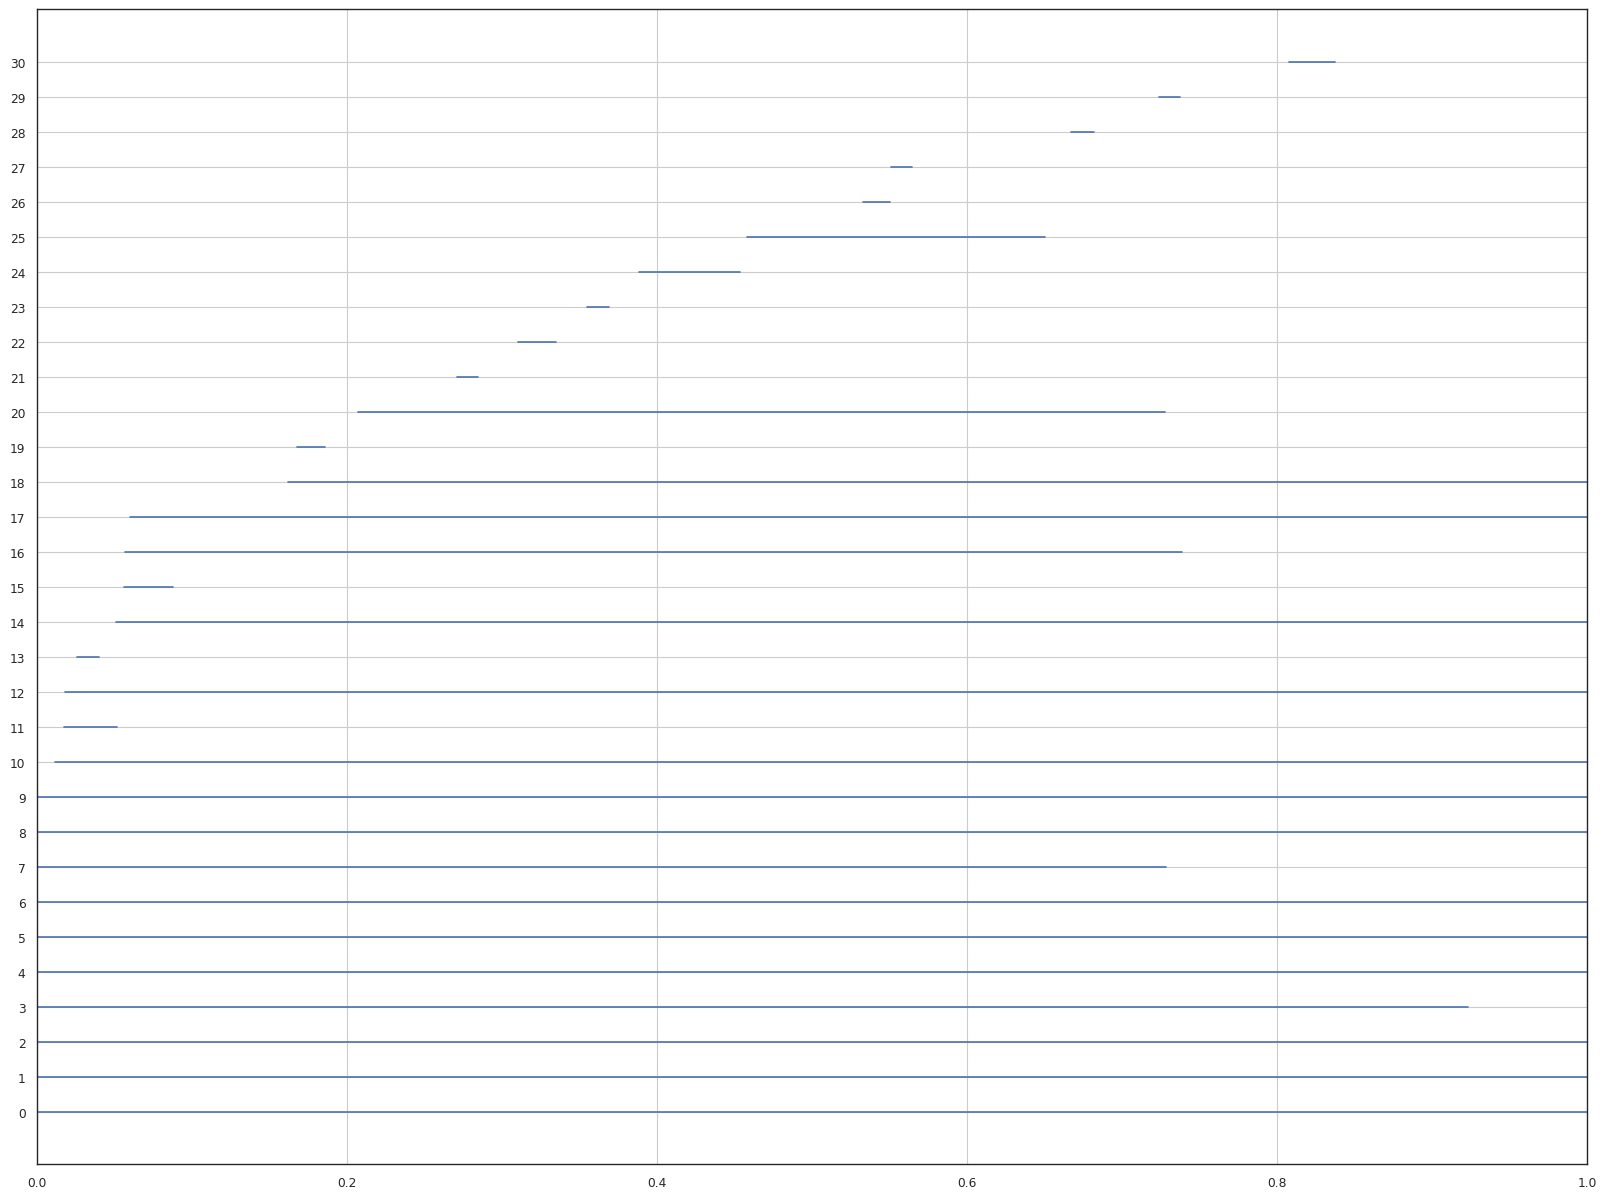

In [15]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [16]:
INSTRUCTOR_ID_THRESHOLD = df_id_start_stop.total_idxs.max()*0.1
instructor_ids = df_id_start_stop[df_id_start_stop.total_idxs < INSTRUCTOR_ID_THRESHOLD]['id'].values
instructor_ids

array([11, 13, 15, 19, 21, 22, 23, 24, 27, 28, 30, 31, 34])

In [17]:
# find random frames to mark for GT from session
# np.random.seed(42)

MAX_SESSION_IDX = df_id_start_stop.max_idx.max()
NUM_SEGMENTS =3
SEG_START_MIN = 0.1
SEG_START_MAX=0.9
SET_SIZE = 60*15
SEGMENT_WINDOW_SIZE = (SEG_START_MAX - SEG_START_MIN)/NUM_SEGMENTS

session_frames = df_tracking_new.index.values.tolist()
selected_frames = []
selected_sets = []

for i in range(NUM_SEGMENTS):    
    seg_window =  np.arange(int((SEG_START_MIN + (i*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX), int((SEG_START_MIN + ((i+1)*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX) - SET_SIZE) 
    seg_set_start = np.random.choice(seg_window)
    seg_set_end = seg_set_start+SET_SIZE
    segment_frames = [xr for xr in session_frames if ((xr >= seg_set_start) and (xr<seg_set_end))]
    selected_sets.append((seg_set_start, seg_set_end, segment_frames))
    selected_frames+=segment_frames        

sprint(selected_sets)

List: selected_sets


[
    (
        10237,
        11137,
        [
            10239,
            10242,
            10245,
            10248,
            10251,
            10254,
            10257,
            10260,
            10263,
            10266,
            10269,
            10272,
            10275,
            10278,
            10281,
            10284,
            10287,
            10290,
            10293,
            10296,
            10299,
            10302,
            10305,
            10308,
            10311,
            10314,
            10317,
            10320,
            10323,
            10326,
            10329,
            10332,
            10335,
            10338,
            10341,
            10344,
            10347,
            10350,
            10353,
            10356,
            10359,
            10362,
            10365,
            10368,
            10371,
            10374,
            10377,
            10380,
            10383,
            10386,
            10389,
            10392,
            10395,
            10398,
            10401,
            10404,
            10407,
            10410,
            10413,
            10416,
            10419,
            10422,
            10425,
            10428,
            10431,
            10434,
            10437,
            10440,
            10443,
            10446,
            10449,
            10452,
            10455,
            10458,
            10461,
            10464,
            10467,
            10470,
            10473,
            10476,
            10479,
            10482,
            10485,
            10488,
            10491,
            10494,
            10497,
            10500,
            10503,
            10506,
            10509,
            10512,
            10515,
            10518,
            10521,
            10524,
            10527,
            10530,
            10533,
            10536,
            10539,
            10542,
            10545,
            10548,
            10551,
            10554,
            10557,
            10560,
            10563,
            10566,
            10569,
            10572,
            10575,
            10578,
            10581,
            10584,
            10587,
            10590,
            10593,
            10596,
            10599,
            10602,
            10605,
            10608,
            10611,
            10614,
            10617,
            10620,
            10623,
            10626,
            10629,
            10632,
            10635,
            10638,
            10641,
            10644,
            10647,
            10650,
            10653,
            10656,
            10659,
            10662,
            10665,
            10668,
            10671,
            10674,
            10677,
            10680,
            10683,
            10686,
            10689,
            10692,
            10695,
            10698,
            10701,
            10704,
            10707,
            10710,
            10713,
            10716,
            10719,
            10722,
            10725,
            10728,
            10731,
            10734,
            10737,
            10740,
            10743,
            10746,
            10749,
            10752,
            10755,
            10758,
            10761,
            10764,
            10767,
            10770,
            10773,
            10776,
            10779,
            10782,
            10785,
            10788,
            10791,
            10794,
            10797,
            10800,
            10803,
            10806,
            10809,
            10812,
            10815,
            10818,
            10821,
            10824,
            10827,
            10830,
            10833,
            10836,
            10839,
            10842,
            10845,
            10848,
            10851,
            10854,
            10857,
            10860,


In [18]:
len(selected_frames)

900

In [19]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [20]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0xb7d7780] error while decoding MB 126 36, bytestream -5
[h264 @ 0xbb7c680] error while decoding MB 126 36, bytestream -5
[h264 @ 0xbc8b4c0] error while decoding MB 65 27, bytestream -9
[h264 @ 0xc20cf40] error while decoding MB 90 53, bytestream -9
[h264 @ 0xbb7c680] error while decoding MB 126 36, bytestream -5
[h264 @ 0xbc8b4c0] error while decoding MB 65 27, bytestream -9
[h264 @ 0xc20cf40] error while decoding MB 90 53, bytestream -9


Looped 0 images


[h264 @ 0xbb53f40] error while decoding MB 71 30, bytestream -25
[h264 @ 0xc20cf40] error while decoding MB 165 17, bytestream -8
[h264 @ 0xbb53f40] error while decoding MB 95 58, bytestream -5
[h264 @ 0xbc8b4c0] error while decoding MB 91 59, bytestream -7
[h264 @ 0xc249e40] error while decoding MB 90 33, bytestream -17
[h264 @ 0xf387f00] error while decoding MB 159 18, bytestream -5
[h264 @ 0xc20cf40] error while decoding MB 183 8, bytestream -5
[h264 @ 0xd023540] error while decoding MB 202 78, bytestream -9
[h264 @ 0xd0f2880] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xd0f2880] error while decoding MB 0 61, bytestream 358176
[h264 @ 0xbc62cc0] error while decoding MB 166 124, bytestream -5
[h264 @ 0xf387f00] error while decoding MB 46 54, bytestream -9
[h264 @ 0xbc8b4c0] error while decoding MB 194 101, bytestream -5
[h264 @ 0xcf54200] error while decoding MB 182 10, bytestream -7
[h264 @ 0xc20cf40] error while decoding MB 90 73, bytestream -9
[h264 @ 0xc221440]

Looped 10000 images


[h264 @ 0xc235940] error while decoding MB 207 105, bytestream -11
[h264 @ 0xc20cf40] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xc20cf40] error while decoding MB 0 32, bytestream 460170
[h264 @ 0xbc8b4c0] cabac decode of qscale diff failed at 12 31
[h264 @ 0xbc8b4c0] error while decoding MB 12 31, bytestream 276481
[h264 @ 0xbb7c680] error while decoding MB 20 133, bytestream -9
[h264 @ 0xbc62cc0] error while decoding MB 201 80, bytestream -5
[h264 @ 0xbb68340] error while decoding MB 149 24, bytestream -5
[h264 @ 0xd023540] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xd023540] error while decoding MB 0 35, bytestream 394977
[h264 @ 0xbc8b4c0] cabac decode of qscale diff failed at 219 27
[h264 @ 0xbc8b4c0] error while decoding MB 219 27, bytestream 381809
[h264 @ 0xcf54200] error while decoding MB 215 28, bytestream -5
[h264 @ 0xbc62cc0] left block unavailable for requested intra mode
[h264 @ 0xbc62cc0] error while decoding MB 0 25, bytestream 52

Looped 20000 images


[h264 @ 0xbc62cc0] cabac decode of qscale diff failed at 105 32
[h264 @ 0xbc62cc0] error while decoding MB 105 32, bytestream 306418
[h264 @ 0xbb7c680] error while decoding MB 88 95, bytestream -5
[h264 @ 0xcf54200] cabac decode of qscale diff failed at 153 27
[h264 @ 0xcf54200] error while decoding MB 153 27, bytestream 423813
[h264 @ 0xc249e40] error while decoding MB 53 64, bytestream -7
[h264 @ 0xbc8b4c0] cabac decode of qscale diff failed at 127 39
[h264 @ 0xbc8b4c0] error while decoding MB 127 39, bytestream 278642
[h264 @ 0xbb7c680] left block unavailable for requested intra mode
[h264 @ 0xbb7c680] error while decoding MB 0 28, bytestream 471725
[h264 @ 0xc221440] error while decoding MB 196 98, bytestream -7
[h264 @ 0xb8bb580] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xb8bb580] error while decoding MB 0 30, bytestream 495453
[h264 @ 0xc221440] error while decoding MB 24 86, bytestream -5
[h264 @ 0xd0f2880] cabac decode of qscale diff failed at 227 43
[h264 

Looped 30000 images


[h264 @ 0xbc8b4c0] cabac decode of qscale diff failed at 44 46
[h264 @ 0xbc8b4c0] error while decoding MB 44 46, bytestream 304272
[h264 @ 0xf387f00] error while decoding MB 46 71, bytestream -5
[h264 @ 0xc249e40] error while decoding MB 198 9, bytestream -5
[h264 @ 0xc235940] error while decoding MB 36 71, bytestream -5
[h264 @ 0xf387f00] left block unavailable for requested intra mode
[h264 @ 0xf387f00] error while decoding MB 0 42, bytestream 390394
[h264 @ 0xb7f3f40] cabac decode of qscale diff failed at 25 32
[h264 @ 0xb7f3f40] error while decoding MB 25 32, bytestream 349913
[h264 @ 0xbb68340] error while decoding MB 117 76, bytestream -5
[h264 @ 0xcf54200] cabac decode of qscale diff failed at 219 31
[h264 @ 0xcf54200] error while decoding MB 219 31, bytestream 308676
[h264 @ 0xbb68340] cabac decode of qscale diff failed at 115 36
[h264 @ 0xbb68340] error while decoding MB 115 36, bytestream 434230
[h264 @ 0xf387f00] cabac decode of qscale diff failed at 68 36
[h264 @ 0xf387f00]

Looped 40000 images


[h264 @ 0xc221440] error while decoding MB 87 36, bytestream -5
[h264 @ 0xd0f2880] left block unavailable for requested intra mode
[h264 @ 0xd0f2880] error while decoding MB 0 78, bytestream 247730
[h264 @ 0xbc62cc0] error while decoding MB 51 130, bytestream -5
[h264 @ 0xd023540] error while decoding MB 3 93, bytestream -34
[h264 @ 0xc221440] error while decoding MB 201 123, bytestream -5
[h264 @ 0xd023540] error while decoding MB 46 49, bytestream -19
[h264 @ 0xc20cf40] cabac decode of qscale diff failed at 226 62
[h264 @ 0xc20cf40] error while decoding MB 226 62, bytestream 325152
[h264 @ 0xc20cf40] error while decoding MB 195 116, bytestream -5
[h264 @ 0xbc770c0] error while decoding MB 198 99, bytestream -7
[h264 @ 0xbb7c680] error while decoding MB 203 56, bytestream -5
[h264 @ 0xbb53f40] error while decoding MB 218 131, bytestream -12
[h264 @ 0xb7f3f40] error while decoding MB 203 114, bytestream -5
[h264 @ 0xc235940] error while decoding MB 190 51, bytestream -9
[h264 @ 0xd0235

Looped 50000 images


[h264 @ 0xbb53f40] cabac decode of qscale diff failed at 203 34
[h264 @ 0xbb53f40] error while decoding MB 203 34, bytestream 232642
[h264 @ 0xb8bb580] error while decoding MB 120 85, bytestream -5
[h264 @ 0xc249e40] left block unavailable for requested intra mode
[h264 @ 0xc249e40] error while decoding MB 0 123, bytestream 36075
[h264 @ 0xc221440] error while decoding MB 203 34, bytestream -15
[h264 @ 0xd023540] error while decoding MB 10 87, bytestream -5


Looped 60000 images


[h264 @ 0xc235940] cabac decode of qscale diff failed at 182 38
[h264 @ 0xc235940] error while decoding MB 182 38, bytestream 366798
[h264 @ 0xc249e40] error while decoding MB 68 57, bytestream -9
[h264 @ 0xbb68340] error while decoding MB 196 46, bytestream -9
[h264 @ 0xd023540] cabac decode of qscale diff failed at 229 24
[h264 @ 0xd023540] error while decoding MB 229 24, bytestream 316154
[h264 @ 0xc221440] cabac decode of qscale diff failed at 80 95
[h264 @ 0xc221440] error while decoding MB 80 95, bytestream 96365
[h264 @ 0xd023540] error while decoding MB 27 64, bytestream -9


Looped 70000 images


In [23]:
# get pose information for this session
case_study_input_cache_file = f"{case_study_input_data}/{sample_session_id}.pb"
_,_,_,_,posture_info,_ = pickle.load(open(case_study_input_cache_file, 'rb'))
id_hand_raise_frames = {}
for sid in posture_info:
    id_hand_raise_frames[sid] = posture_info[sid][posture_info[sid].armPose=='handsRaised'].index.values.tolist()
    
    


In [24]:
id_hand_raise_frames[0]

[225,
 3129,
 3132,
 3135,
 3138,
 9729,
 18627,
 18630,
 55044,
 55047,
 55050,
 55053,
 55056,
 55059,
 55908,
 55911,
 55917,
 55920,
 55923,
 55926,
 55929,
 55932,
 55935,
 57486,
 57489,
 57492]

In [27]:
import cv2
session_id_viz_dir = f'{case_study_viz_cache_root}/{sample_session_id}'
font = cv2.FONT_HERSHEY_DUPLEX
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, segment_frames) in enumerate(selected_sets):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}_new.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                new_id = old_to_new_id_map[old_id]
                # if new_id in instructor_ids:
                #     new_id = 1000+new_id
                frame_tracking_results[person_idx]['track_id'] =new_id
            frame_tracking_results =  [xr for xr in frame_tracking_results if ((not (xr['track_id']==10000)) and (frame_idx in id_hand_raise_frames[xr['track_id']]))]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_img = cv2.putText(frame_img,
                   f'frame_idx:{frame_idx}',
                   (frame_img.shape[1]//2, frame_img.shape[0]//2+1000),
                   font, 2,
                   (255, 255, 255),
                   2)
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
                # cv2.imwrite(f'frame_test/{frame_idx}.jpg',frame_track_img)
            else:
                cv2.imwrite(frame_file_out,frame_img)
                
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=10, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-09-13 20:11:41,120 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-13 20:11:41,276 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-13 20:11:41,277 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-13 20:11:41,278 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-13 20:11:41,610 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector